/Users/adrianlopez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/adrianlopez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
2025-06-18 23:47:55.079906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Processing Dataset_1...

Saved scaler to Dataset_1_scaler_mc.pkl

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 1.5184, R2: 0.0059
Saved SVR model to Dataset_1_SVR_mc.pkl

Final evaluation on test set for Dataset_1:

SVR Model:
Evaluation -- MSE: 1.5839, R2: 0.0147


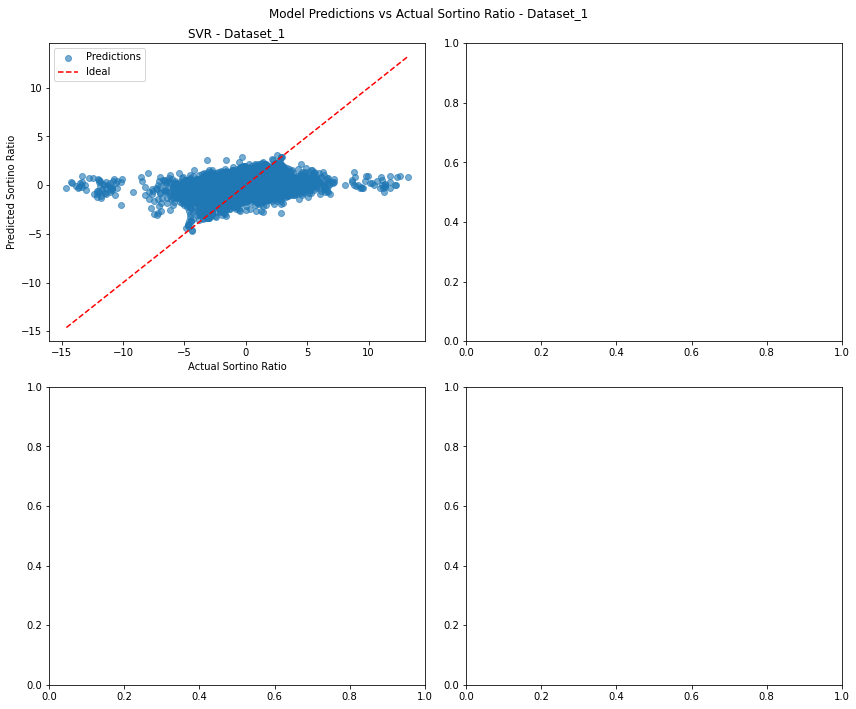

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Classes import LinearRegressionModel, NeuralNetworkModel, SVRModel, XGBoostModel

dataset_paths = [
    "daily_dbs/sortino_daily_MidCap.csv"
]

# Load and split data
def load_and_split_data(file_path, dataset_name):
    df = pd.read_csv(file_path).drop(columns=['Portfolio_Returns', 'Unnamed: 0', 'Date'])
    
    # Split into features (X) and target (y)
    X = df.drop(columns='Sortino_Ratio')
    y = df['Sortino_Ratio']

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler for future use
    with open(f"{dataset_name}_scaler_mc.pkl", "wb") as f:
        pickle.dump(scaler, f)
        print(f"Saved scaler to {dataset_name}_scaler_mc.pkl")

    # Split data into train (70%), validation (15%), and test (15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Train and save models
def train_models(X_train, y_train, X_val, y_val, dataset_name):
    models = {}

    print("\nTraining SVR Model...")
    svr_model = SVRModel()
    svr_model.fit(X_train, y_train)
    svr_model.evaluate(X_val, y_val)
    models["SVR"] = svr_model

    # Save models
    for model_name, model in models.items():
        with open(f"{dataset_name}_{model_name}_mc.pkl", "wb") as f:
            pickle.dump(model, f)
        print(f"Saved {model_name} model to {dataset_name}_{model_name}_mc.pkl")

    return models

# Plot predictions vs actuals
def plot_model_results(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):
        preds = model.predict(X_test)
        ax.scatter(y_test, preds, alpha=0.6, label='Predictions')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
        ax.set_xlabel("Actual Sortino Ratio")
        ax.set_ylabel("Predicted Sortino Ratio")
        ax.set_title(f"{name} - {dataset_name}")
        ax.legend()

    plt.suptitle(f"Model Predictions vs Actual Sortino Ratio - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Main process
def main():
    for i, dataset_path in enumerate(dataset_paths):
        dataset_name = f"Dataset_{i+1}"

        print(f"\nProcessing {dataset_name}...\n")
        X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_path, dataset_name)

        models = train_models(X_train, y_train, X_val, y_val, dataset_name)

        print(f"\nFinal evaluation on test set for {dataset_name}:")
        for name, model in models.items():
            print(f"\n{name} Model:")
            model.evaluate(X_test, y_test)

        plot_model_results(models, X_test, y_test, dataset_name)

if __name__ == "__main__":
    main()
